In [ ]:
import torch
from torch import nn, optim
import math
import matplotlib.pyplot as plt
if torch.cuda.is_available():
  device=torch.device('cuda')
else:
  device = torch.device('cpu')
print(device)
import torchvision
import torchvision.transforms as transforms
import math
import os


cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

In [ ]:
batch_size = 32
# Load the training set
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Create a batched data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()
    self.model = nn.Sequential(
                          # 28*28*1
                          nn.Conv2d(1, latent_dim, 4, stride=2, padding=1, bias=False), # 14*14*8
                          nn.LeakyReLU(0.2, inplace=True),
                          nn.Conv2d(latent_dim, latent_dim*2, 4, stride=2, padding=1, bias=False), # 7*7*16
                          nn.BatchNorm2d(latent_dim*2),
                          nn.LeakyReLU(0.2, inplace=True),
                          nn.Conv2d(latent_dim*2, latent_dim*4, 3, stride=2, padding=1, bias=False), # 4*4*32
                          nn.BatchNorm2d(latent_dim*4),
                          nn.LeakyReLU(0.2, inplace=True),
                          nn.Conv2d(latent_dim*4,1,4,stride=1, padding=0, bias=False),
                          nn.Sigmoid()
    )

  def forward(self, x):
    x = x.view(-1, 1, 28, 28)
    output = self.model(x)
    return output

In [ ]:
discriminator = Discriminator(16).to(device)

In [ ]:
class Generator(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()
    # we consider 100 samples for input
    self.model = nn.Sequential(
                          nn.ConvTranspose2d(100, latent_dim*4, 4, stride=1, padding=0, bias=False), # 4*4
                          nn.BatchNorm2d(latent_dim*4),
                          nn.ReLU(True), 
                          nn.ConvTranspose2d(latent_dim*4, latent_dim*2, 4, stride=2, padding=1, bias=False), # 8*8
                          nn.BatchNorm2d(latent_dim*2),
                          nn.ReLU(True), 
                          nn.ConvTranspose2d(latent_dim*2, latent_dim, 4, stride=2, padding=1, bias=False), # 16*16
                          nn.BatchNorm2d(latent_dim),
                          nn.ReLU(True), 
                          nn.ConvTranspose2d(latent_dim, 1, 4, stride=2, padding=3), # 28*28
                          nn.Tanh()
    )

  def forward(self, x):
    x = x.view(x.size(0), -1, 1, 1)
    #print(x.shape)
    output = self.model(x)
    output = output.view(x.size(0), 1, 28, 28)
    return output

In [ ]:
generator = Generator(16).to(device)

In [ ]:
lr = 0.0002
num_epochs = 20
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

Epoch: 0 Loss D.: 0.20412278175354004
Epoch: 0 Loss G.: 1.6027295589447021
Epoch: 1 Loss D.: 0.14642611145973206
Epoch: 1 Loss G.: 2.370880603790283
Epoch: 2 Loss D.: 0.1728399693965912
Epoch: 2 Loss G.: 1.9931614398956299
Epoch: 3 Loss D.: 0.26226016879081726
Epoch: 3 Loss G.: 1.5761529207229614
Epoch: 4 Loss D.: 0.48160120844841003
Epoch: 4 Loss G.: 0.6487029790878296
Epoch: 5 Loss D.: 0.18080779910087585
Epoch: 5 Loss G.: 3.0935792922973633
Epoch: 6 Loss D.: 0.34184369444847107
Epoch: 6 Loss G.: 1.4754955768585205
Epoch: 7 Loss D.: 0.16812998056411743
Epoch: 7 Loss G.: 2.4827020168304443
Epoch: 8 Loss D.: 0.23409512639045715
Epoch: 8 Loss G.: 1.7847671508789062
Epoch: 9 Loss D.: 0.18264871835708618
Epoch: 9 Loss G.: 2.024893283843994
Epoch: 10 Loss D.: 0.09619951993227005
Epoch: 10 Loss G.: 4.286108016967773
Epoch: 11 Loss D.: 0.10296520590782166
Epoch: 11 Loss G.: 2.4789912700653076
Epoch: 12 Loss D.: 0.11753375828266144
Epoch: 12 Loss G.: 2.451061964035034
Epoch: 13 Loss D.: 0.730

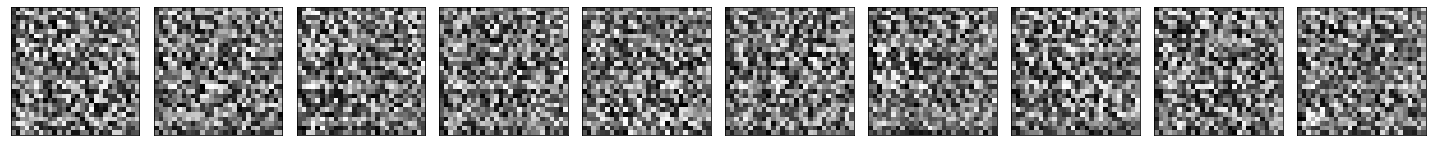

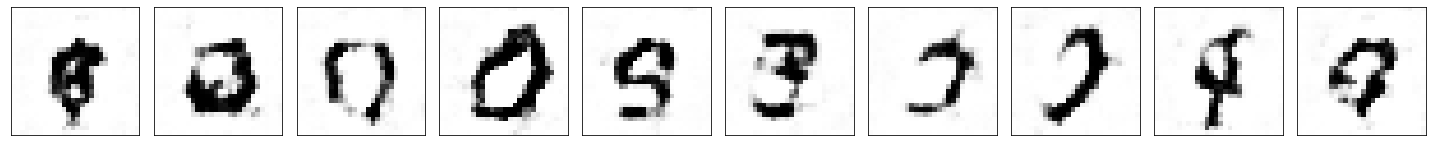

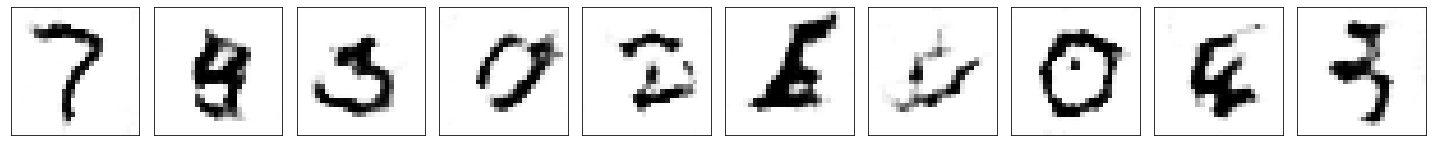

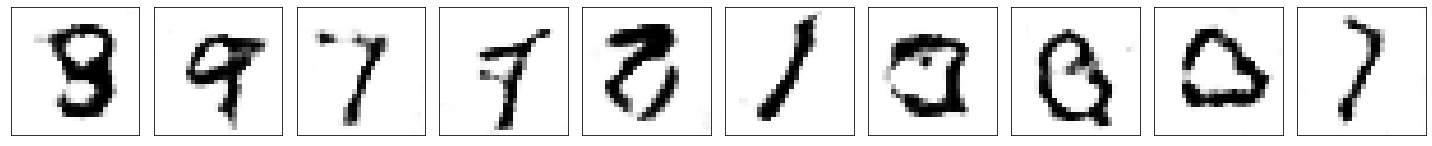

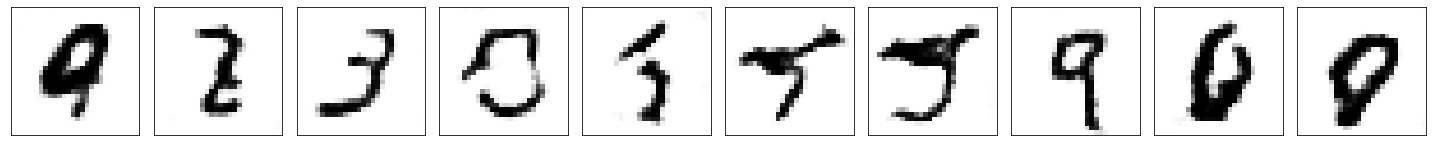

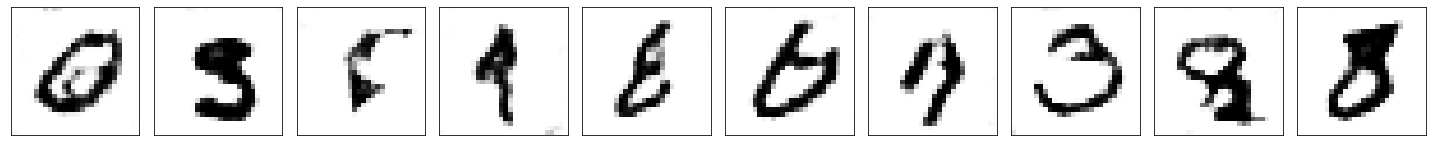

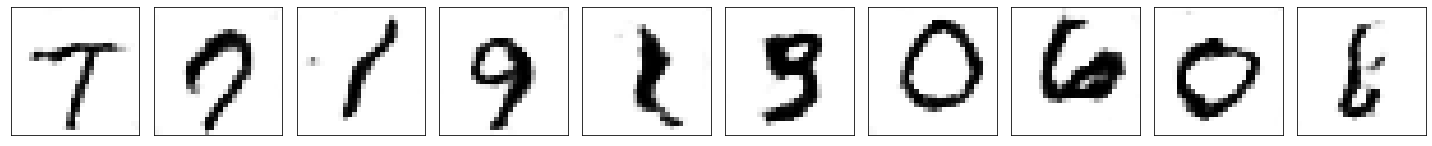

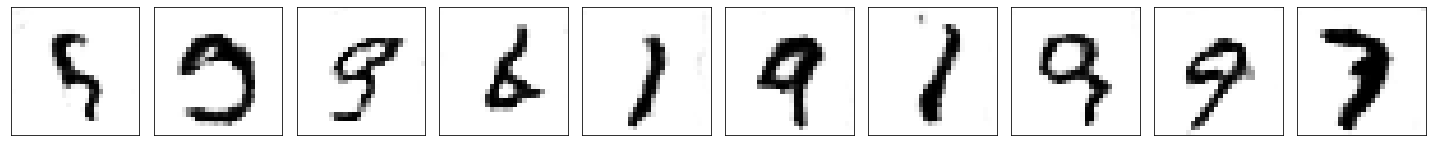

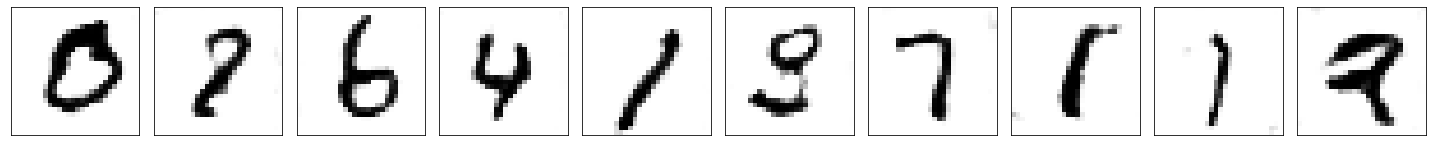

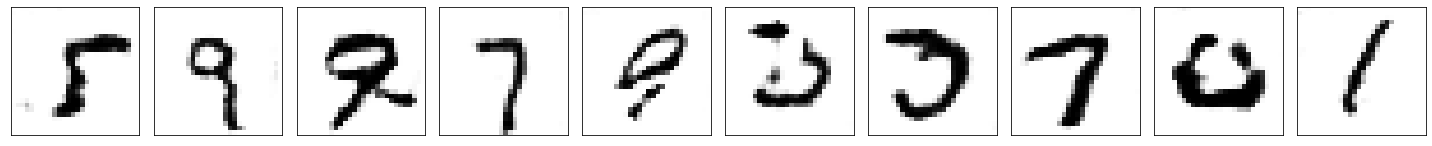

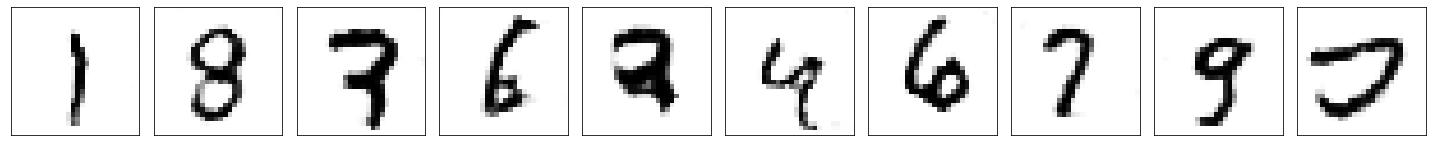

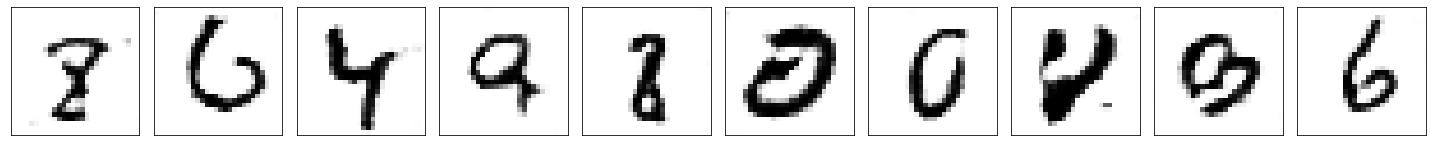

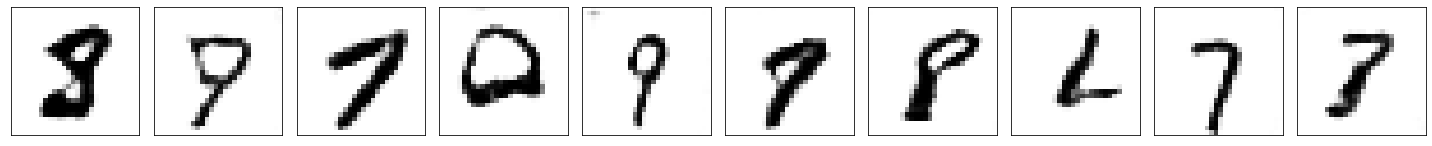

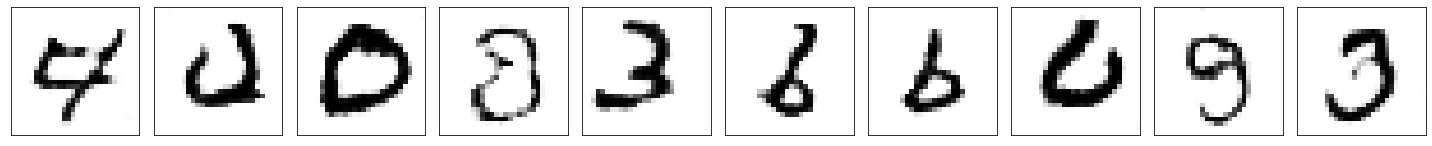

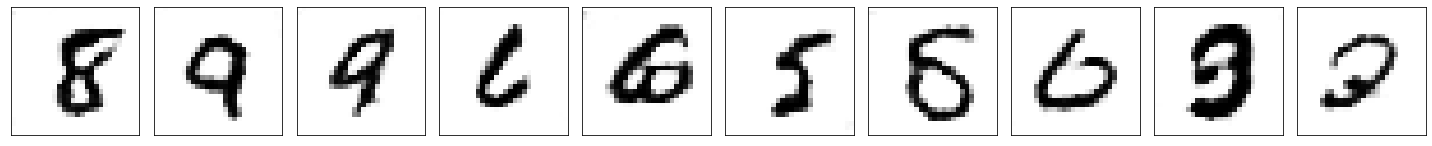

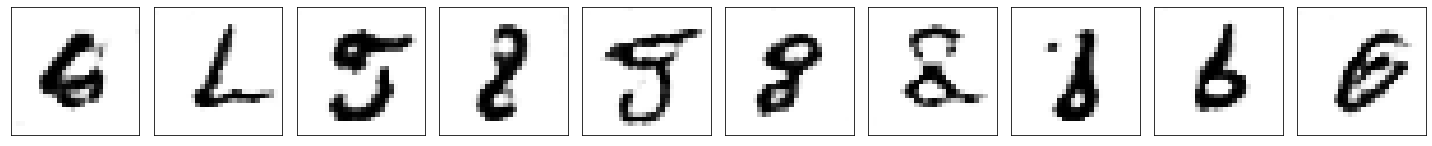

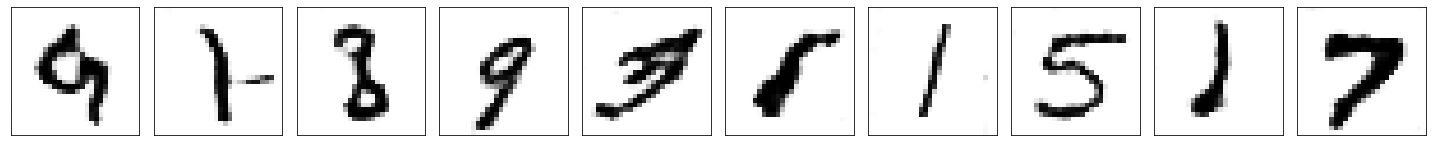

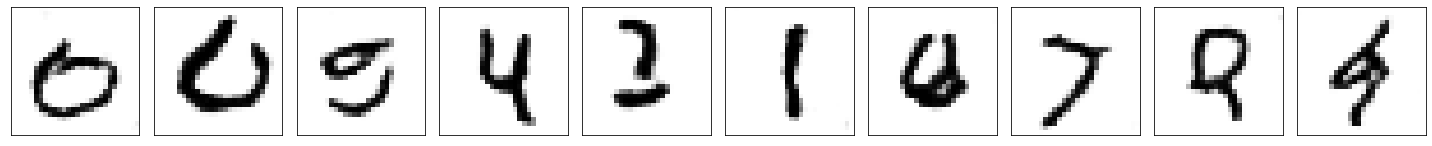

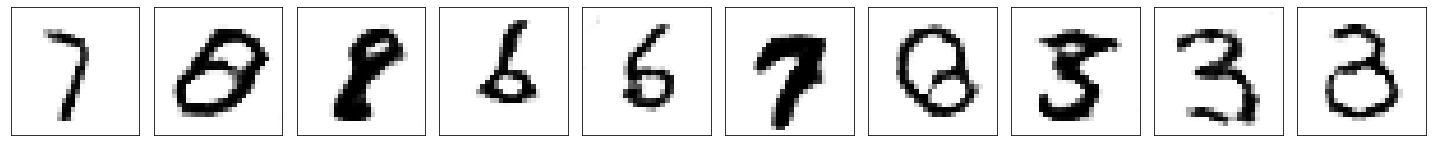

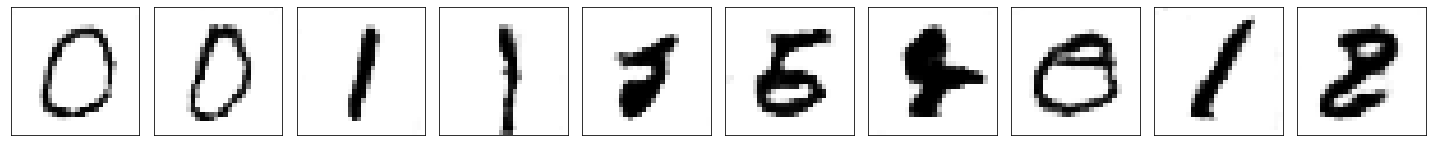

In [ ]:
# Load trained NN when it exists, or train a new NN
if os.path.isfile('discriminator.pt') and os.path.isfile('generator.pt'):
    discriminator.load_state_dict(torch.load('./discriminator.pt'))
    generator.load_state_dict(torch.load('./generator.pt'))   
else:
    for epoch in range(num_epochs):
        for n, (real_samples, mnist_labels) in enumerate(train_loader):
        
            ######################
            # YOUR CODE GOES HERE
            ######################
            latent_space_samples_plot = torch.randn((batch_size, 100)).to(device=device)
            gen = generator.forward(latent_space_samples_plot)
            
            dis_real = discriminator.forward(real_samples.to(device))
            loss_discriminator_real = loss_function(dis_real.reshape(batch_size,-1), torch.ones((batch_size,1), device=device))
            
            dis_gen_out = discriminator.forward(gen.detach())
            loss_discriminator_gen = loss_function(dis_gen_out.reshape(batch_size, -1), torch.zeros((batch_size,1), device=device))
            
            loss_discriminator = (loss_discriminator_gen + loss_discriminator_real)/2
            
            optimizer_discriminator.zero_grad()
            loss_discriminator.backward()
            optimizer_discriminator.step()

            gen_dis_out = discriminator.forward(gen)
            loss_generator = loss_function(gen_dis_out.reshape(batch_size, -1), torch.ones((batch_size,1), device=device))

            optimizer_generator.zero_grad()
            loss_generator.backward()
            optimizer_generator.step()
            # Show loss
            if n == batch_size - 1:
                print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
                print(f"Epoch: {epoch} Loss G.: {loss_generator}")
                fig = plt.figure(figsize=(20,5))
                for i in range(10):
                  ax = plt.subplot(1, 10, i+1)
                  plt.imshow(gen[i].detach().cpu().reshape(28, 28), cmap='gray_r')
                  plt.xticks([])
                  plt.yticks([])
                  plt.tight_layout()    